# LR3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Загрузка данных
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

# Пример использования
data = load_data('XAU_15m_data_2004_to_2024-20-09.csv')

In [2]:
# 2. Подготовка данных
def create_features(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Нормализация данных
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Создание признаков и целевой переменной
X, y = create_features(data_scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### 3. Обучение моделей

In [3]:
from sklearn.linear_model import LogisticRegression

n_samples = X_train.shape[0]  # Количество образцов
n_features = X_train.shape[-1]  # Количество признаков

X_train_lr = X_train.reshape(n_samples, -1)  # Преобразование в 2D

y_direction = (y_train[1:] > y_train[:-1]).astype(int)  # Направление изменения цены

print(f"Size of y_direction before trimming: {y_direction.shape[0]}")

# Обучение модели
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_lr[:-1], y_direction.ravel())  


Size of y_direction before trimming: 371740


LogisticRegression(random_state=42)

In [4]:
from sklearn.svm import SVR

print(f"Original shape of X_train: {X_train.shape}")

# Изменяем размерность X_train для SVR
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Преобразование в 2D
print(f"Reshaped X_train to: {X_train_reshaped.shape}")

# Обучение модели
svm_model = SVR(kernel='rbf')
print("Training the SVR model...")
svm_model.fit(X_train_reshaped, y_train.ravel())
print("Model training completed.")

# Проверка параметров модели
print("Model parameters:")
print(f"Kernel: {svm_model.kernel}")
print(f"Number of support vectors: {len(svm_model.support_)}")

# Прогнозирование на тестовом наборе
y_pred = svm_model.predict(X_test.reshape(X_test.shape[0], -1))
print(f"Predictions shape: {y_pred.shape}")
print("First 5 predictions:", y_pred[:5])

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"SVR - MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Original shape of X_train: (371741, 60, 1)
Reshaped X_train to: (371741, 60)
Training the SVR model...
Model training completed.
Model parameters:
Kernel: rbf
Number of support vectors: 4
Predictions shape: (92936,)
First 5 predictions: [0.63529991 0.63508842 0.63481726 0.63457347 0.63432849]
SVR - MAE: 0.1088, RMSE: 0.1567


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample

print(f"Original shape of X_train: {X_train.shape}")

# Изменяем размерность X_train для Random Forest
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Преобразование в 2D
print(f"Reshaped X_train to: {X_train_reshaped.shape}")

# Случайная выборка (например, 40% от исходных данных)
X_train_sampled, y_train_sampled = resample(X_train_reshaped, y_train, n_samples=int(len(y_train) * 0.1), random_state=42)

# Обучение модели с уменьшенным количеством деревьев и использованием всех ядер процессора
rf_model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_sampled, y_train_sampled.ravel())


Original shape of X_train: (371741, 60, 1)
Reshaped X_train to: (371741, 60)


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [23]:
from xgboost import XGBRegressor

# Проверка формы X_train
print(f"Original shape of X_train: {X_train.shape}")

# Изменяем размерность X_train для XGBoost
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Преобразование в 2D
print(f"Reshaped X_train to: {X_train_reshaped.shape}")

# Обучение модели
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_reshaped, y_train.ravel())


Original shape of X_train: (371741, 60, 1)
Reshaped X_train to: (371741, 60)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(model, X_test, y_test):
    if len(X_test.shape) > 2:
        X_test = X_test.reshape(X_test.shape[0], -1)  # Преобразование в 2D

    y_pred = model.predict(X_test).reshape(-1, 1)  # Прогнозируем
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return mae, rmse

# Оценка моделей
lr_mae, lr_rmse = evaluate_model(lr_model, X_test[1:], y_test[1:])
svm_mae, svm_rmse = evaluate_model(svm_model, X_test, y_test)
rf_mae, rf_rmse = evaluate_model(rf_model, X_test, y_test)
xgb_mae, xgb_rmse = evaluate_model(xgb_model, X_test, y_test)

# Вывод результатов
print(f'Logistic Regression - MAE: {lr_mae:.4f}, RMSE: {lr_rmse:.4f}')
print(f'SVM - MAE: {svm_mae:.4f}, RMSE: {svm_rmse:.4f}')
print(f'Random Forest - MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}')
print(f'XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}')


Logistic Regression - MAE: 0.3006, RMSE: 0.3143
SVM - MAE: 0.1088, RMSE: 0.1567
Random Forest - MAE: 0.0194, RMSE: 0.0531
XGBoost - MAE: 0.0268, RMSE: 0.0644


Original shape of X_test: (92936, 60, 1)


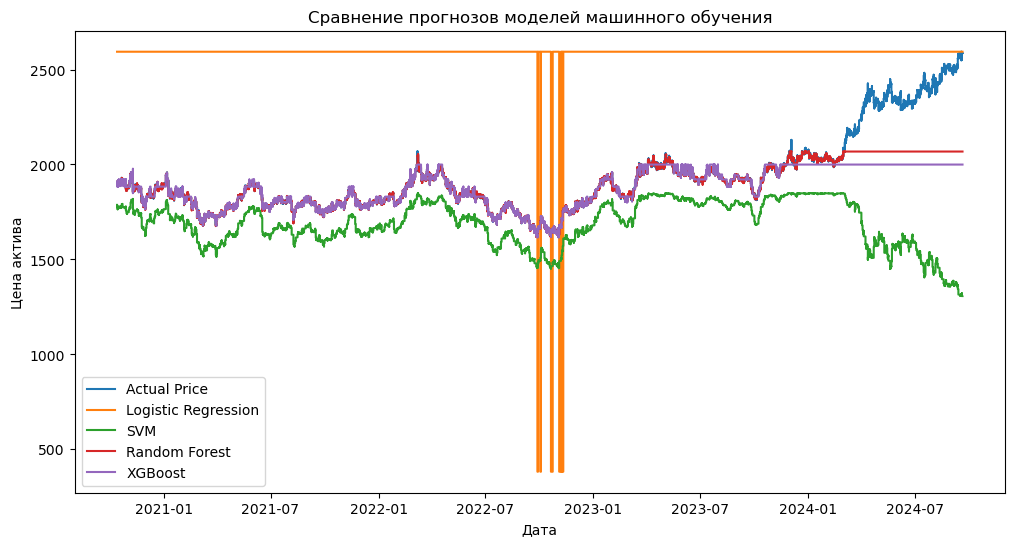

In [25]:
import matplotlib.pyplot as plt

print(f"Original shape of X_test: {X_test.shape}")

# Изменяем размерность X_test для всех моделей
if len(X_test.shape) > 2:
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  # Преобразование в 2D
else:
    X_test_reshaped = X_test

# Оценка моделей и сохранение прогнозов
lr_pred = lr_model.predict(X_test_reshaped[1:]).reshape(-1, 1)  # Прогноз для логистической регрессии
svm_pred = svm_model.predict(X_test_reshaped).reshape(-1, 1)    # Прогноз для SVM
rf_pred = rf_model.predict(X_test_reshaped).reshape(-1, 1)      # Прогноз для случайного леса
xgb_pred = xgb_model.predict(X_test_reshaped).reshape(-1, 1)    # Прогноз для XGBoost

# Визуализация результатов
plt.figure(figsize=(12, 6))

actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(data.index[-len(actual_prices):], actual_prices, label='Actual Price')

# Визуализация предсказаний
plt.plot(data.index[-len(lr_pred):], scaler.inverse_transform(lr_pred), label='Logistic Regression')
plt.plot(data.index[-len(svm_pred):], scaler.inverse_transform(svm_pred), label='SVM')
plt.plot(data.index[-len(rf_pred):], scaler.inverse_transform(rf_pred), label='Random Forest')
plt.plot(data.index[-len(xgb_pred):], scaler.inverse_transform(xgb_pred), label='XGBoost')

plt.title('Сравнение прогнозов моделей машинного обучения')
plt.xlabel('Дата')
plt.ylabel('Цена актива')
plt.legend()
plt.show()


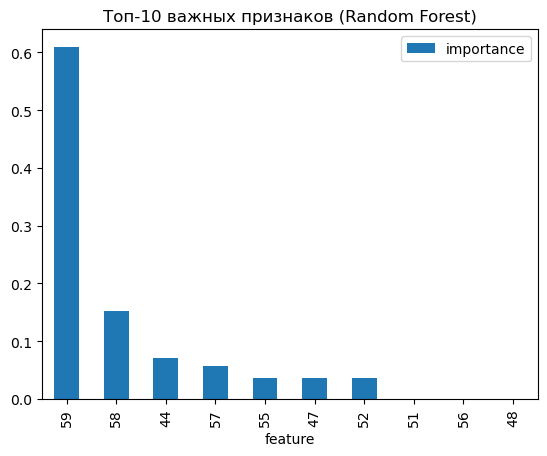

In [26]:
# Анализ важности признаков (для Random Forest)
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': rf_model.feature_importances_})
feature_importance.sort_values('importance', ascending=False).head(10).plot(kind='bar', x='feature', y='importance')
plt.title('Топ-10 важных признаков (Random Forest)')
plt.show()